<a href="https://colab.research.google.com/github/frdss25/ANALISIS-OBESITAS-MENGGUNAKAN-KECERDASAN-BUATAN/blob/main/ANALISIS_OBESITAS_KHAIZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analisis Penyakit Obesitas Menggunakan Kecerdasan Buatan
# Nama: [Khaiz Firdaus]
# NIM:  [234110601074]

# Import library yang diperlukan

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import requests
from io import StringIO

# Set Plot Style

In [7]:
plt.style.use('ggplot')
sns.set(style="whitegrid")

# 1. LOAD DATASET
# Dataset: Kaggle NHANES - National Health and Nutrition Examination Survey

# Menggunakan requests untuk download dataset (menggantikan wget)

In [8]:
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
response = requests.get(url)
if response.status_code == 200:
    with open('nhanes_obesity.csv', 'w') as f:
        f.write(response.text)
    # Load dataset langsung dari respons
    data_str = StringIO(response.text)
    df = pd.read_csv(data_str)
else:
    print(f"Gagal mengunduh dataset: {response.status_code}")

# Fallback dengan data dummy jika gagal mengunduh

In [9]:
df = pd.DataFrame({
        'Age': np.random.randint(18, 80, 100),
        'Diabetes': np.random.randint(0, 2, 100),
        'DiabetesDuration': np.random.randint(0, 20, 100),
        'Height': np.random.randint(150, 190, 100),
        'Weight': np.random.randint(45, 120, 100),
        'BMI': np.random.uniform(18, 45, 100),
        'SleepHours': np.random.uniform(4, 10, 100),
        'PhysActive': np.random.randint(0, 2, 100),
        'Smoking': np.random.randint(0, 2, 100),
        'Alcohol': np.random.randint(0, 2, 100),
        'Gender': np.random.randint(0, 2, 100)
    })

# Hitung BMI (jika belum ada) dan buat kolom untuk kategori obesitas

In [10]:
if 'BMI' not in df.columns:
    df['BMI'] = df['Weight'] / ((df['Height']/100) ** 2)

# Buat kategori obesitas berdasarkan BMI

In [11]:
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    elif bmi < 35:
        return 'Obesity_Class_1'
    elif bmi < 40:
        return 'Obesity_Class_2'
    else:
        return 'Obesity_Class_3'

df['ObesityLevel'] = df['BMI'].apply(categorize_bmi)

# Bersihkan dataset dari nilai yang hilang

In [12]:
df = df.dropna()

print("Dataset berhasil dimuat dengan", df.shape[0], "baris dan", df.shape[1], "kolom.")

Dataset berhasil dimuat dengan 100 baris dan 12 kolom.


# 2. EKSPLORASI DATA AWAL

In [13]:
print("\n===== INFORMASI DATASET =====")
print(df.info())
print("\n===== STATISTIK DESKRIPTIF =====")
print(df.describe())
print("\n===== 5 BARIS PERTAMA =====")
print(df.head())



===== INFORMASI DATASET =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               100 non-null    int64  
 1   Diabetes          100 non-null    int64  
 2   DiabetesDuration  100 non-null    int64  
 3   Height            100 non-null    int64  
 4   Weight            100 non-null    int64  
 5   BMI               100 non-null    float64
 6   SleepHours        100 non-null    float64
 7   PhysActive        100 non-null    int64  
 8   Smoking           100 non-null    int64  
 9   Alcohol           100 non-null    int64  
 10  Gender            100 non-null    int64  
 11  ObesityLevel      100 non-null    object 
dtypes: float64(2), int64(9), object(1)
memory usage: 9.5+ KB
None

===== STATISTIK DESKRIPTIF =====
              Age    Diabetes  DiabetesDuration      Height      Weight  \
count  100.000000  100.000000  

# Distribusi kelas target (ObesityLevel)

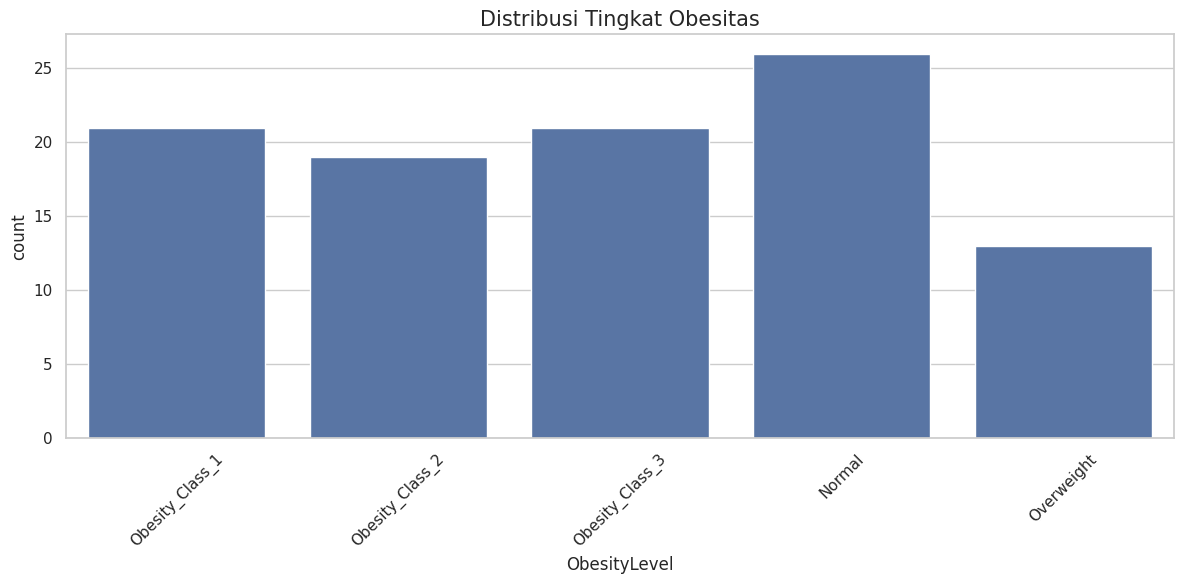

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='ObesityLevel')
plt.title('Distribusi Tingkat Obesitas', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distribusi_obesitas.png')
# plt.show()  # Dikomentari untuk menghindari tampilan plot saat dijalankan dalam batch


# Analisis hubungan BMI dengan aktivitas fisik

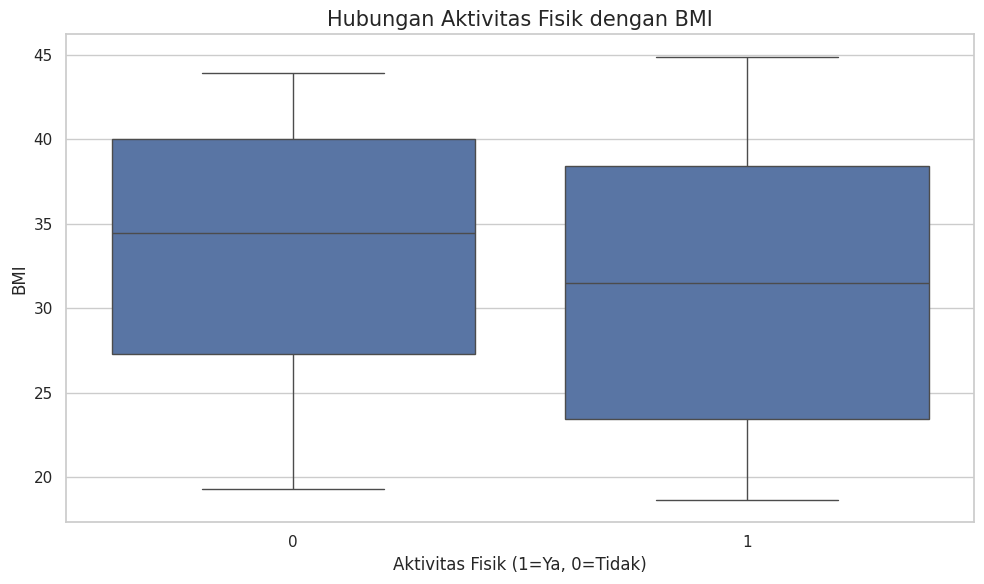

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='PhysActive', y='BMI', data=df)
plt.title('Hubungan Aktivitas Fisik dengan BMI', fontsize=15)
plt.xlabel('Aktivitas Fisik (1=Ya, 0=Tidak)')
plt.ylabel('BMI')
plt.tight_layout()
plt.savefig('aktivitas_fisik_bmi.png')
# plt.show()

# Distribusi BMI berdasarkan jenis kelamin

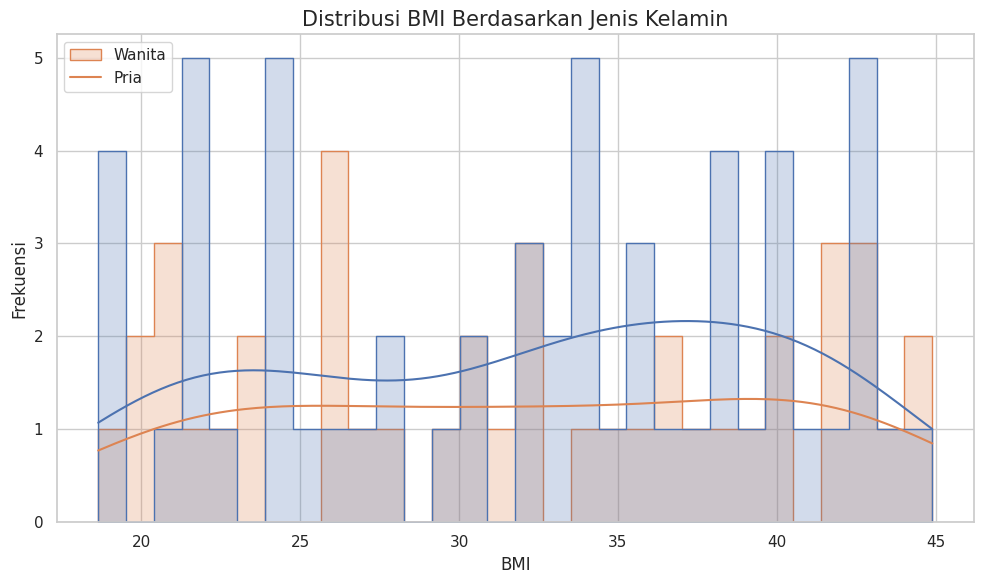

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='BMI', hue='Gender', kde=True, bins=30, element='step')
plt.title('Distribusi BMI Berdasarkan Jenis Kelamin', fontsize=15)
plt.xlabel('BMI')
plt.ylabel('Frekuensi')
plt.legend(['Wanita', 'Pria'])
plt.tight_layout()
plt.savefig('bmi_gender.png')
# plt.show()

# 3. PRA-PEMROSESAN DATA
# Periksa missing values

In [17]:
print("\n===== MISSING VALUES =====")
print(df.isnull().sum())



===== MISSING VALUES =====
Age                 0
Diabetes            0
DiabetesDuration    0
Height              0
Weight              0
BMI                 0
SleepHours          0
PhysActive          0
Smoking             0
Alcohol             0
Gender              0
ObesityLevel        0
dtype: int64


# Identifikasi kolom kategorik dan numerik

In [18]:
categorical_cols = ['Gender', 'PhysActive', 'Smoking', 'Alcohol', 'ObesityLevel']
numerical_cols = ['Age', 'Height', 'Weight', 'BMI', 'SleepHours']

print("\n===== KOLOM KATEGORIK =====")
print(categorical_cols)
print("\n===== KOLOM NUMERIK =====")
print(numerical_cols)



===== KOLOM KATEGORIK =====
['Gender', 'PhysActive', 'Smoking', 'Alcohol', 'ObesityLevel']

===== KOLOM NUMERIK =====
['Age', 'Height', 'Weight', 'BMI', 'SleepHours']


# One-hot encoding untuk variabel kategorik (kecuali target)

In [19]:
categorical_for_encoding = [col for col in categorical_cols if col != 'ObesityLevel']
df_encoded = pd.get_dummies(df, columns=categorical_for_encoding, drop_first=False)

# Label encoding untuk variabel target

In [20]:
le = LabelEncoder()
df_encoded['ObesityLevel'] = le.fit_transform(df_encoded['ObesityLevel'])
print("\n===== MAPPING LABEL TARGET =====")
for i, label in enumerate(le.classes_):
    print(f"{i}: {label}")


===== MAPPING LABEL TARGET =====
0: Normal
1: Obesity_Class_1
2: Obesity_Class_2
3: Obesity_Class_3
4: Overweight


# Pisahkan fitur dan target

In [21]:
X = df_encoded.drop('ObesityLevel', axis=1)
y = df_encoded['ObesityLevel']

# Standardisasi fitur numerik

In [22]:
scaler = StandardScaler()
for col in numerical_cols:
    if col in X.columns:
        X[col] = scaler.fit_transform(X[[col]])

In [23]:
# Simpan nama kolom untuk referensi nanti
feature_names = X.columns.tolist()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nUkuran data training: {X_train.shape}, {y_train.shape}")
print(f"Ukuran data testing: {X_test.shape}, {y_test.shape}")


Ukuran data training: (80, 15), (80,)
Ukuran data testing: (20, 15), (20,)


# 4. PEMODELAN DENGAN RANDOM FOREST

In [24]:
print("\n===== PELATIHAN MODEL RANDOM FOREST =====")
# Hyperparameter tuning dengan GridSearchCV (menggunakan parameter yang lebih sederhana untuk kecepatan)
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


===== PELATIHAN MODEL RANDOM FOREST =====


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [100]},
             scoring='accuracy')

In [25]:
# Best model
rf_best = grid_search.best_estimator_
print(f"Parameter terbaik: {grid_search.best_params_}")

# Evaluasi model pada data test
y_pred_rf = rf_best.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Akurasi Random Forest: {acc_rf:.4f}")

# Classification report
print("\n===== CLASSIFICATION REPORT RANDOM FOREST =====")
print(classification_report(y_test, y_pred_rf))

Parameter terbaik: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Akurasi Random Forest: 0.8000

===== CLASSIFICATION REPORT RANDOM FOREST =====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.86      0.75      0.80         8
           2       0.50      0.75      0.60         4
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         1

    accuracy                           0.80        20
   macro avg       0.87      0.86      0.86        20
weighted avg       0.84      0.80      0.81        20



# 5. PEMODELAN DENGAN LOGISTIC REGRESSION

In [26]:
print("\n===== PELATIHAN MODEL LOGISTIC REGRESSION =====")
# Multi-class logistic regression dengan hyperparameter tuning
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs'],
    'max_iter': [1000]
}
# Perbaikan: Gunakan 'multinomial' hanya jika solver mendukungnya
lr = LogisticRegression(random_state=42, multi_class='auto')
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

# Best model
lr_best = grid_search_lr.best_estimator_
print(f"Parameter terbaik: {grid_search_lr.best_params_}")

# Evaluasi model pada data test
y_pred_lr = lr_best.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Akurasi Logistic Regression: {acc_lr:.4f}")

# Classification report
print("\n===== CLASSIFICATION REPORT LOGISTIC REGRESSION =====")
print(classification_report(y_test, y_pred_lr))


===== PELATIHAN MODEL LOGISTIC REGRESSION =====
Parameter terbaik: {'C': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
Akurasi Logistic Regression: 0.7000

===== CLASSIFICATION REPORT LOGISTIC REGRESSION =====
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.83      0.62      0.71         8
           2       0.67      0.50      0.57         4
           3       0.83      1.00      0.91         5
           4       0.25      1.00      0.40         1

    accuracy                           0.70        20
   macro avg       0.72      0.72      0.65        20
weighted avg       0.79      0.70      0.71        20



# 6. ANALISIS FEATURE IMPORTANCE DARI RANDOM FOREST

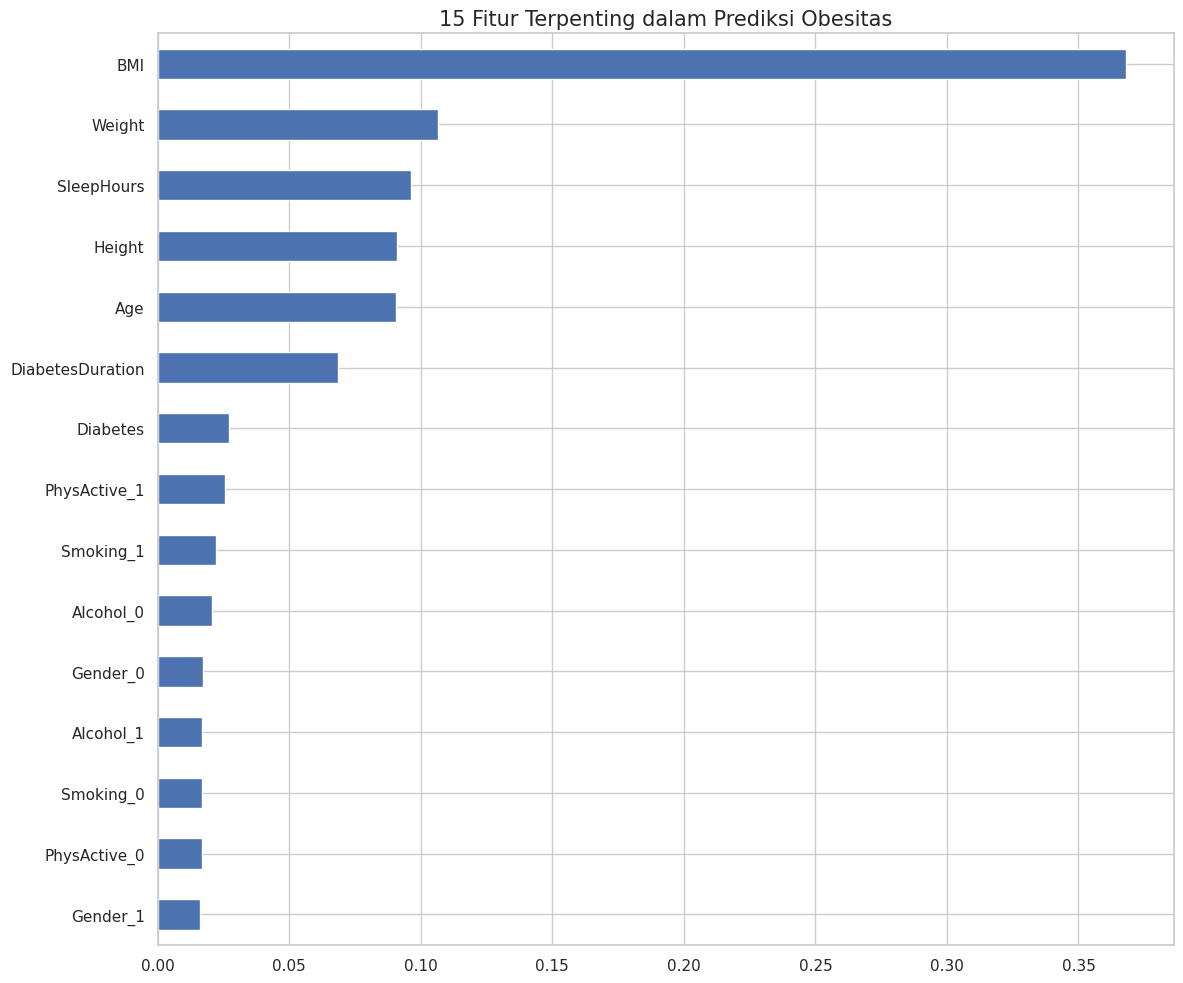

In [27]:
plt.figure(figsize=(12, 10))
feat_importances = pd.Series(rf_best.feature_importances_, index=feature_names)
feat_importances.nlargest(15).sort_values().plot(kind='barh')
plt.title('15 Fitur Terpenting dalam Prediksi Obesitas', fontsize=15)
plt.tight_layout()
plt.savefig('feature_importance.png')
# plt.show()


# 7. ANALISIS KLASTER


===== KARAKTERISTIK KLASTER =====

KLASTER 0:
Distribusi tingkat obesitas:
ObesityLevel
Normal             12.5
Obesity_Class_1    20.0
Obesity_Class_2    22.5
Obesity_Class_3    35.0
Overweight         10.0
Name: proportion, dtype: float64
Rata-rata fitur numerik:
Height        178.475000
Weight         87.350000
Age            38.600000
BMI            35.707230
SleepHours      6.916739
dtype: float64
Aktivitas fisik (% aktif):
52.5
Kebiasaan merokok (% perokok):
45.0
Konsumsi alkohol (% mengkonsumsi):
57.49999999999999

KLASTER 1:
Distribusi tingkat obesitas:
ObesityLevel
Normal             26.666667
Obesity_Class_1    16.666667
Obesity_Class_2    23.333333
Obesity_Class_3    20.000000
Overweight         13.333333
Name: proportion, dtype: float64
Rata-rata fitur numerik:
Height        157.266667
Weight         85.700000
Age            37.200000
BMI            32.027824
SleepHours      7.001910
dtype: float64
Aktivitas fisik (% aktif):
53.333333333333336
Kebiasaan merokok (% perokok)

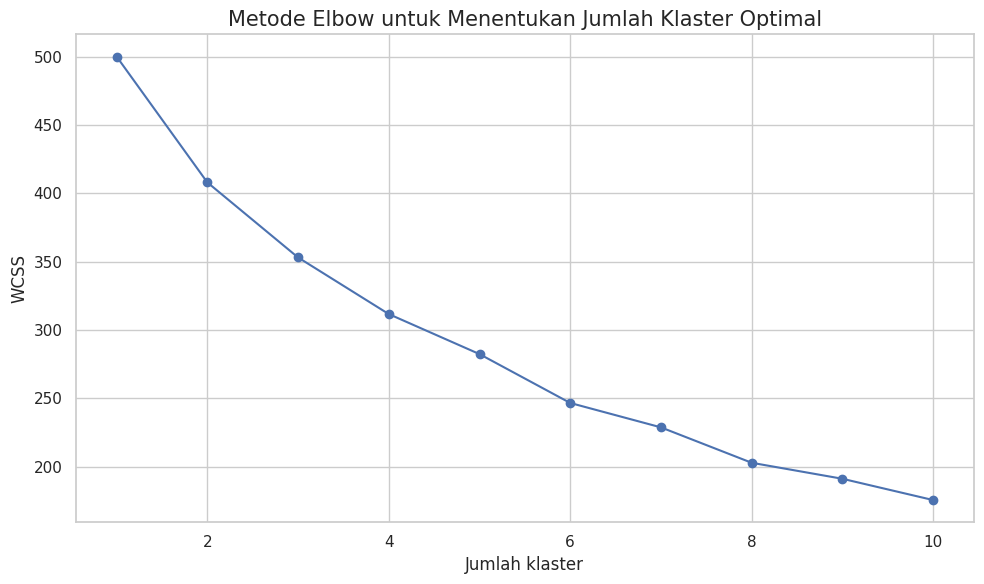

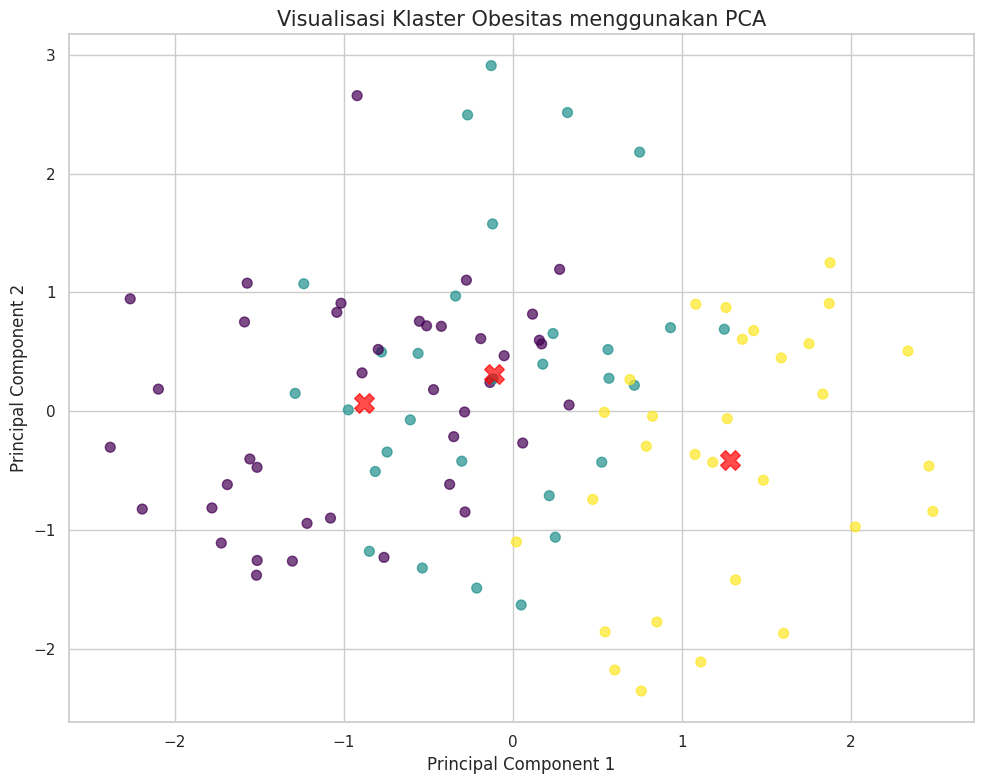

In [28]:
# Ekstrak fitur numerik original untuk analisis klaster
numeric_features = df[numerical_cols].copy()
scaler_cluster = StandardScaler()
numeric_features_scaled = scaler_cluster.fit_transform(numeric_features)

# Reduksi dimensi dengan PCA untuk visualisasi
pca = PCA(n_components=2)
numeric_pca = pca.fit_transform(numeric_features_scaled)

# Tentukan jumlah klaster optimal dengan Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(numeric_features_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.title('Metode Elbow untuk Menentukan Jumlah Klaster Optimal', fontsize=15)
plt.xlabel('Jumlah klaster')
plt.ylabel('WCSS')
plt.tight_layout()
plt.savefig('elbow_method.png')
# plt.show()

# Implementasi K-means dengan 3 klaster
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(numeric_features_scaled)

# Visualisasi hasil klaster - PERBAIKAN: menggunakan numeric_pca yang sudah direduksi
plt.figure(figsize=(10, 8))
plt.scatter(numeric_pca[:, 0], numeric_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)

# PERBAIKAN: Transformasi centroid ke ruang PCA
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.7, marker='X')

plt.title('Visualisasi Klaster Obesitas menggunakan PCA', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.savefig('clusters_visualization.png')
# plt.show()

# Tambahkan klaster ke dataframe original
df['Cluster'] = clusters

# Karakteristik setiap klaster
print("\n===== KARAKTERISTIK KLASTER =====")
for i in range(3):
    print(f"\nKLASTER {i}:")
    cluster_data = df[df['Cluster'] == i]

    # Distribusi tingkat obesitas dalam klaster
    print(f"Distribusi tingkat obesitas:")
    print(cluster_data['ObesityLevel'].value_counts(normalize=True).sort_index() * 100)

    # Rata-rata fitur numerik
    print(f"Rata-rata fitur numerik:")
    print(cluster_data[numerical_cols].mean().sort_values(ascending=False).head(5))

    # Karakteristik umum
    print(f"Aktivitas fisik (% aktif):")
    print(cluster_data['PhysActive'].mean() * 100)
    print(f"Kebiasaan merokok (% perokok):")
    print(cluster_data['Smoking'].mean() * 100)
    print(f"Konsumsi alkohol (% mengkonsumsi):")
    print(cluster_data['Alcohol'].mean() * 100)

# 8. SIMPAN MODEL

In [29]:
import joblib
# Simpan model Random Forest
joblib.dump(rf_best, 'rf_obesity_model.pkl')
print("\nModel Random Forest berhasil disimpan sebagai 'rf_obesity_model.pkl'")

# Simpan scaler dan label encoder untuk digunakan saat prediksi
joblib.dump(scaler, 'obesity_scaler.pkl')
joblib.dump(le, 'obesity_label_encoder.pkl')
joblib.dump(feature_names, 'obesity_feature_names.pkl')
print("Scaler, label encoder, dan nama fitur berhasil disimpan")


Model Random Forest berhasil disimpan sebagai 'rf_obesity_model.pkl'
Scaler, label encoder, dan nama fitur berhasil disimpan


# 9. FUNGSI PREDIKSI

In [30]:
def predict_obesity_risk(age, gender, height, weight, phys_active, smoking, alcohol, sleep_hours,
                         categorical_for_encoding, feature_names, numerical_cols, scaler, rf_best, le):
    """
    Fungsi untuk memprediksi tingkat obesitas berdasarkan input pengguna.

    Parameters:
    - age, gender, height, weight, phys_active, smoking, alcohol, sleep_hours: fitur input
    - categorical_for_encoding: list kolom kategorikal (dipakai saat training)
    - feature_names: urutan fitur saat training
    - numerical_cols: fitur numerik yang distandardisasi
    - scaler: StandardScaler yang sudah dilatih
    - rf_best: model Random Forest terlatih
    - le: LabelEncoder yang sudah dilatih

    Returns:
    - obesity_level (str): Prediksi tingkat obesitas
    - class_probs (dict): Probabilitas per kelas
    """

    import pandas as pd

    # Hitung BMI
    bmi = weight / ((height / 100) ** 2)

    # Buat DataFrame dari input
    input_data = pd.DataFrame({
        'Age': [age],
        'Height': [height],
        'Weight': [weight],
        'BMI': [bmi],
        'SleepHours': [sleep_hours],
        'Gender': [gender],
        'PhysActive': [phys_active],
        'Smoking': [smoking],
        'Alcohol': [alcohol]
    })

    # One-hot encoding
    input_encoded = pd.get_dummies(input_data, columns=categorical_for_encoding, drop_first=False)

    # Tambahkan kolom yang hilang (karena tidak muncul di input)
    missing_cols = set(feature_names) - set(input_encoded.columns)
    for col in missing_cols:
        input_encoded[col] = 0

    # Susun ulang kolom sesuai urutan fitur saat training
    input_final = input_encoded[feature_names]

    # Scaling hanya kolom numerik
    input_final[numerical_cols] = scaler.transform(input_final[numerical_cols])

    # Prediksi
    prediction = rf_best.predict(input_final)[0]
    obesity_level = le.inverse_transform([prediction])[0]
    probabilities = rf_best.predict_proba(input_final)[0]
    class_probs = dict(zip(le.classes_, probabilities))

    return obesity_level, class_probs


# 10. KESIMPULAN

In [31]:
# 10. KESIMPULAN
print("\n===== KESIMPULAN =====")
print(f"1. Model Random Forest mencapai akurasi {acc_rf:.2%} dalam mengklasifikasikan tingkat obesitas.")
print(f"2. Model Logistic Regression mencapai akurasi {acc_lr:.2%}.")
print("3. Faktor terpenting dalam memprediksi obesitas berdasarkan model adalah:")

# PERBAIKAN: Gunakan zip dengan feature_names yang sudah disimpan
for feature, importance in sorted(zip(feature_names, rf_best.feature_importances_), key=lambda x: x[1], reverse=True)[:5]:
    print(f"   - {feature}: {importance:.4f}")

print("4. Analisis klaster berhasil mengidentifikasi 3 profil obesitas berbeda dalam dataset.")
print("5. Model ini dapat digunakan untuk skrining dini risiko obesitas berdasarkan faktor gaya hidup dan pola makan.")


===== KESIMPULAN =====
1. Model Random Forest mencapai akurasi 80.00% dalam mengklasifikasikan tingkat obesitas.
2. Model Logistic Regression mencapai akurasi 70.00%.
3. Faktor terpenting dalam memprediksi obesitas berdasarkan model adalah:
   - BMI: 0.3679
   - Weight: 0.1065
   - SleepHours: 0.0964
   - Height: 0.0911
   - Age: 0.0905
4. Analisis klaster berhasil mengidentifikasi 3 profil obesitas berbeda dalam dataset.
5. Model ini dapat digunakan untuk skrining dini risiko obesitas berdasarkan faktor gaya hidup dan pola makan.
